In [90]:
import numpy as np 
import matplotlib.pyplot as plt 
import glob
import soundfile as sf
import librosa
import acoustics
from tr_augmentation import get_audio_list, tr_augmentation
rir_path = '/mnt/datasets/impulsos/reales/C4DM'
audio_list = get_audio_list(rir_path)
rir, fs = librosa.load(audio_list[0], sr=16000)
TR_DESEADO = 1.6

# Aumentacion Directo-Reverberado
Dado un impulso, se aplica un ventana temporal sobre la parte temprana, para variar los niveles de amplitud de manera de conseguir diferentes relacions directo-reverberado

In [83]:
rir, fs = tr_augmentation(rir, fs, 2.0)

El DRR resultante es: -9.22


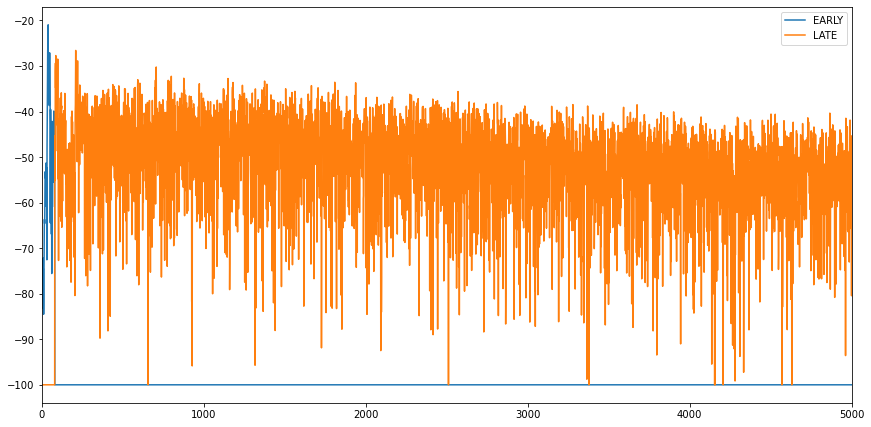

In [91]:
#calculo de DRR 
t_d = np.argmax(rir) # direct path                                                     
t_o = int((0.0025) * fs) #tolerance window in samples                      
init_idx = t_d - t_o                                                                   
final_idx = t_d + t_o + 1                                                              

if init_idx < 0:                                                                       
    init_idx = 0                                                                       
if final_idx > len(rir)-1:                                                             
    final_idx = len(rir)-1                                                             

early= rir[init_idx:final_idx]                                                         
late = rir[final_idx:] 

late = np.concatenate((np.zeros(len(early)),late))
early = np.concatenate((early, np.zeros(len(late))))

DRR = 10*np.log10((early**2).sum()/(late**2).sum())

def get_DRR(rir):
    t_d = np.argmax(rir) # direct path                                                     
    t_o = int((0.0050) * fs) #tolerance window in samples                      
    init_idx = t_d - t_o                                                                   
    final_idx = t_d + t_o + 1                                                              

    if init_idx < 0:                                                                       
        init_idx = 0                                                                       
    if final_idx > len(rir)-1:                                                             
        final_idx = len(rir)-1                                                             

    early= rir[init_idx:final_idx]                                                         
    late = rir[final_idx:] 

    late = np.concatenate((np.zeros(len(early)),late))
    early = np.concatenate((early, np.zeros(len(late))))

    DRR = 10*np.log10((early**2).sum()/(late**2).sum())
    return DRR, early, late
    
print('El DRR resultante es: {:0.2f}'.format(DRR))
plt.plot(librosa.amplitude_to_db(early), label='EARLY')
plt.plot(librosa.amplitude_to_db(late), label='LATE')
plt.xlim(0,5000)
plt.legend()
plt.subplots_adjust(right=2, top=1.5)


In [92]:
def drr_aug(rir, DRR_buscado, window_lenght=0.0025):
    """Realiza la generacion de una nueva respuesta al impulso con diferente
    valor de relacion directo-reverberado. El limite inferior queda determinado por 
    el valor maximo de la parte tardia del impulso. La parte tardia y temprana se dividen 
    con tolerancias temporales de 2.5 ms hacia ambos lados del valor maximo global, por
    convencion. Para aplicar la amplificacion o atenuacion de la parte temprana se utilizan
    ventanas de hamming, evitando la generacion de discontinuidades o artefactos.
    
    Parametros
    ------------------------------------------------------------------------
    path : string : path del audio a transformar
    DRR_buscado : float : valor de DRR resultante esperado
    
    Salidas 
    ------------------------------------------------------------------------
    rir_aug : numpy array : secuencia numerica del nuevo impulso generado. corresponde
    a una fs de 16000.
    """
    t_d = np.argmax(rir) # direct path                                                     
    t_o = int((window_lenght) * fs) #tolerance window in samples                      
    init_idx = t_d - t_o                                                                   
    final_idx = t_d + t_o + 1                                                              

    if init_idx < 0:                                                                       
        init_idx = 0                                                                       
    if final_idx > len(rir)-1:                                                             
        final_idx = len(rir)-1     
        
    delay = rir[:init_idx]
    early= rir[init_idx:final_idx]                                                         
    late = rir[final_idx:] 
    
    #Busco el coeficiente para llegar a la DRR deseada
    w = np.hamming((t_o*2)+1) #ventana de hamming de 5ms
    a = np.sum((w**2) * (early**2))
    b = 2 * np.sum((1-w)*w*(early**2))
    c = np.sum(((1-w)**2)*(early**2))-(np.power(10,DRR_buscado/10)*np.sum(late**2))
    alpha = bhaskara(a, b, c)
    
    #Defino la nueva parte early
    new_early = (alpha * w * early) + ((1 - w)*early) 
    if np.max(abs(new_early))<np.max(abs(late)):
        print("El nivel deseado es demasiado bajo")
        new_early = early
    
    
    #formo el nuevo impulso
    rir_aug = np.concatenate((delay, new_early, late), dtype='float32')
    
    DRR = 10*np.log10((new_early**2).sum()/(late**2).sum())
    print("DRR buscado: {:0.2f}, DRR obtenido: {:0.2f}".format(DRR_buscado, DRR))
    return rir_aug

def bhaskara(a, b, c):
    r = b**2 - 4*a*c
    if r > 0:
        num_roots = 2
        x1 = (((-b) + np.sqrt(r))/(2*a))     
        x2 = (((-b) - np.sqrt(r))/(2*a))
        return np.max((x1, x2))
    elif r == 0:
        num_roots = 1
        x = (-b) / 2*a
        return x 
    else:
        num_roots = 0
        return 


In [97]:
rir_drr_aug = drr_aug(rir, 0)

DRR buscado: 0.00, DRR obtenido: 0.00


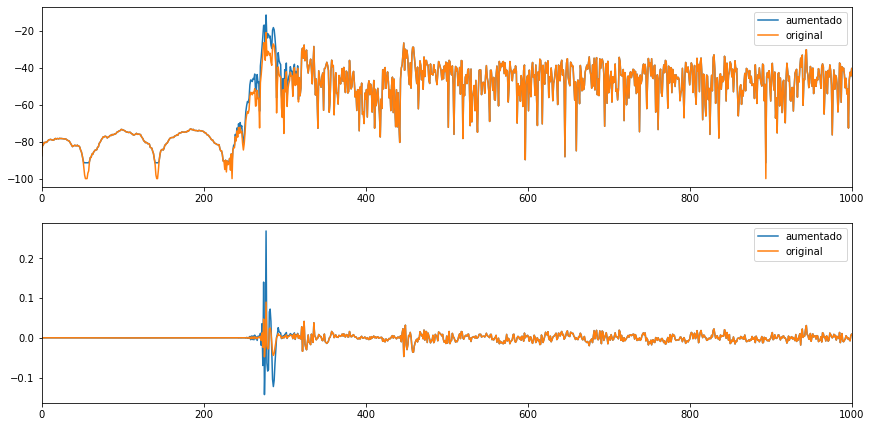

In [98]:
plt.subplot(2,1,1)

plt.plot(librosa.amplitude_to_db(rir_drr_aug), label = 'aumentado')
plt.plot(librosa.amplitude_to_db(rir), label = 'original')
plt.xlim(0,1000)
plt.legend()

plt.subplot(2,1,2)
plt.plot(rir_drr_aug, label = 'aumentado')
plt.plot(rir, label = 'original')

plt.xlim(0,1000)
plt.legend()

plt.subplots_adjust(right=2, top=1.5)

In [99]:
rir[0].dtype

dtype('float32')

In [96]:
type(rir_drr_aug[0])

numpy.float32